In [1]:
import pandas as pd
import numpy as np
import folium
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta

In [2]:
fuca = pd.read_csv('./data/fuca_1.csv')

In [3]:
fuca['MMSI'].value_counts()

367098550    41893
367384780    41314
367530080    41193
366772750    40771
366773030    40606
             ...  
367774000        1
316013966        1
316026345        1
367733390        1
367376170        1
Name: MMSI, Length: 2364, dtype: int64

In [ ]:
rec1 = fuca[fuca['MMSI'] == 367384780].sort_values('BaseDateTime', ascending=True).reset_index(drop=True)

In [ ]:
rec1

In [ ]:
Dk = rec1['Length'].min() * 0.001 * 4.5

def is_stopping_point(prev, cur):
    a = prev[0] - cur['LAT']
    b = prev[1] - cur['LON']
    dist = math.sqrt((a*a + b*b)) * 111.32
    if dist < Dk:
        return True
    else:
        return False

In [ ]:
moving_points = []
stopping_points = []
index = []
# for cluster_id in rec1['cluster'].unique():
    # if cluster_id != -1:
    # cluster = rec1[rec1['cluster'] == cluster_id].reset_index(drop=True)
cluster = rec1.reset_index(drop=True)
cur_loc = cluster.loc[0]
index.append(0)
moving_points.append((cur_loc['LAT'], cur_loc['LON']))
for i in range(len(cluster)):
    cur_loc = cluster.loc[i]
    prev_loc = moving_points[-1]
    if is_stopping_point(prev_loc, cur_loc):
        stopping_points.append((cur_loc['LAT'], cur_loc['LON']))
    else:
        moving_points.append((cur_loc['LAT'], cur_loc['LON']))
        index.append(i)


In [ ]:
index = []
moving_points = []
cur_loc = rec1.loc[0]
index.append(0)
start_index = 0
end_index = 0
flag = -1
moving_points.append((cur_loc['LAT'], cur_loc['LON']))

for i in range(1, len(rec1)):
    cur_loc = cluster.loc[i]
    prev_loc = moving_points[-1]
    if is_stopping_point(prev_loc, cur_loc):
        if flag == 0:
            start_index = i
            flag = 1
    else:
        if flag == 1:
            end_index = i-1
            flag = 0
            term = pd.to_datetime(rec1['BaseDateTime'][end_index]) - pd.to_datetime(rec1['BaseDateTime'][start_index])
            if term < timedelta(minutes=120):
                index.extend(x for x in range(start_index, end_index+1))
        elif flag == -1:
            flag = 0

        moving_points.append((cur_loc['LAT'], cur_loc['LON']))
        index.append(i)


In [ ]:
len(index)

In [ ]:
new_index = []
new_index.append(index[0])
temp = []
cnt = 0
for i in range(1, len(index)):
    temp.append(index[i])
    if index[i]-index[i-1] > 1:
        if cnt > 20:
            new_index.extend(temp)
            cnt = 0
            temp = []
        else:
            temp = []
            cnt = 0
    else:
        cnt += 1

In [ ]:
temp = []
temp.extend([x for x in range(33, 60)])

In [ ]:
len(new_index)

In [ ]:
len(rec1)

In [ ]:
color = ['r', 'g', 'b']
color_map = []
flag = 0
for i in range(len(new_index)):
    if new_index[i] - new_index[i - 1] > 1:
        flag += 1
        color_map.append(color[flag % 3])
    else:
        color_map.append(color[flag % 3])

In [ ]:
moving = rec1.reset_index(drop=True).iloc[index]

In [ ]:
moving['x'] = ((moving["LON"] + 180) / 360) * (2 ** 16)
moving['y'] = (1 - np.log(np.tan(math.pi * moving["LAT"] / 180) + 1 / np.cos(math.pi * moving["LAT"] / 180)) / math.pi) * (2 ** (16 - 1))

In [ ]:
moving

In [ ]:
MT1 = moving.loc[3592:3746]

In [ ]:
MT1

In [ ]:
MT1.plot(kind='scatter', x='x', y='y', figsize=(10,10), s=3)
plt.show()

In [ ]:
len(MT1)

In [ ]:
MT1.info()

In [ ]:
MT1['BaseDateTime'].to_datetime()

In [ ]:
from datetime import datetime, timedelta

In [ ]:
pd.to_datetime(MT1['BaseDateTime'].loc[3592]) + timedelta(minutes=60)

In [ ]:
MT1_1 = MT1[pd.to_datetime(MT1['BaseDateTime']) <= pd.to_datetime(MT1['BaseDateTime'].loc[3592]) + timedelta(minutes=60)]

In [ ]:
MT1_1

In [ ]:
MT1_1['x'].min(), MT1_1['x'].max()

In [ ]:
MT1_1['y'].min(), MT1_1['y'].max()

In [ ]:
((np.ceil(MT1_1['x'].max()) - np.floor(MT1_1['x'].min())) + (np.ceil(MT1_1['y'].max()) - np.floor(MT1_1['y'].min()))) * 2

In [ ]:
MT1_1.reset_index()

In [ ]:
moving.reset_index(inplace=True)

In [ ]:
moving

In [ ]:
moving['index'][1]

In [ ]:
MT_index = []
for i in range(1, len(moving['index'])):
    diff = moving['index'][i] - moving['index'][i-1]
    if diff > 1:
        MT_index.append(i)

In [ ]:
MT_index

In [ ]:
len(MT_index)

In [ ]:
MT1 = moving.iloc[1:170]

In [ ]:
MT1

In [ ]:
((np.ceil(MT1['x'].max()) - np.floor(MT1['x'].min())) + (np.ceil(MT1['y'].max()) - np.floor(MT1['y'].min()))) * 2

In [ ]:
n_o = []
for i in range(len(MT1)):
    n_o.append((np.floor(MT1['x'].iloc[i]), np.floor(MT1['y'].iloc[i])))

In [ ]:
len(set(n_o))

In [ ]:
n_c = 0
for i in range(len(MT1)-1):
    dx = np.abs(np.floor(MT1.iloc[i]['x']) - np.floor(MT1.iloc[i+1]['x']))
    dy = np.abs(np.floor(MT1.iloc[i]['y']) - np.floor(MT1.iloc[i+1]['y']))
    n_c += max(max(dx, dy)-1, 0)

In [ ]:
cnt = 0
for i in range(len(MT_index)-1):
    if MT_index[i+1] - MT_index[i] < 120: continue
    MT = moving.iloc[MT_index[i]:MT_index[i+1]]
    n_o = []
    for j in range(len(MT)):
        n_o.append((np.floor(MT.iloc[j]['x']), np.floor(MT.iloc[j]['y'])))
    n_o = len(set(n_o))
    n_c = 0
    for j in range(len(MT)-1):
        dx = np.abs(np.floor(MT.iloc[j]['x']) - np.floor(MT.iloc[j+1]['x']))
        dy = np.abs(np.floor(MT.iloc[j]['y']) - np.floor(MT.iloc[j+1]['y']))
        n_c += max(max(dx, dy)-1, 0)
    n = n_o + n_c
    c = ((np.ceil(MT['x'].max()) - np.floor(MT['x'].min())) + (np.ceil(MT['y'].max()) - np.floor(MT['y'].min()))) * 2
    if n >= c: cnt += 1
    print(n_o, n_c, n, c)
print(cnt)

In [58]:
fuca

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,367479990,2017-01-01T00:00:03,48.15891,-122.67268,0.1,10.1,353.0,WSF KENNEWICK,IMO9618331,WDF6991,1012.0,moored,83.39,19.50,3.2,NaN
1,367585430,2017-01-01T00:00:12,48.51293,-122.60735,0.0,-101.2,511.0,MAKARIOS,NaN,WDG9205,1019.0,NaN,18.11,5.10,NaN,NaN
2,316021351,2017-01-01T00:00:00,49.29479,-123.13286,0.0,-118.3,511.0,BRITANNIA,IMO8120650,VY5348,1012.0,under way using engine,38.41,9.76,2.8,60.0
3,367536390,2017-01-01T00:00:39,48.68218,-123.40237,0.0,82.1,511.0,APRIL LOON II,NaN,WDG4420,1019.0,NaN,14.94,4.70,NaN,NaN
4,316005771,2017-01-01T00:00:47,48.95017,-125.55641,0.0,-94.6,511.0,WESTERN INVESTOR,IMO7927788,VG6273,1001.0,NaN,24.06,7.17,2.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20501871,367420850,2017-01-31T23:42:40,47.63768,-122.33877,0.0,-49.6,88.0,SPIRIT,NaN,WDE9749,1019.0,moored,16.95,5.10,NaN,37.0
20501872,316028652,2017-01-31T23:43:59,49.20391,-123.14538,-0.1,-49.6,309.0,NEW FRONTIER,NaN,NaN,1019.0,under way using engine,19.08,5.90,1.4,37.0
20501873,316028652,2017-01-31T23:51:20,49.20389,-123.14539,-0.1,-49.6,305.0,NEW FRONTIER,NaN,NaN,1019.0,under way using engine,19.08,5.90,1.4,37.0
20501874,316028652,2017-01-31T23:52:41,49.20391,-123.14539,-0.1,-49.6,307.0,NEW FRONTIER,NaN,NaN,1019.0,under way using engine,19.08,5.90,1.4,37.0


In [ ]:
fuca['MMSI'].value_counts()

In [20]:
fuca[fuca['MMSI']==367081260]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
38,367081260,2017-01-01T00:01:12,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
145,367081260,2017-01-01T00:02:22,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
147,367081260,2017-01-01T00:03:32,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
150,367081260,2017-01-01T00:04:41,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
1611,367081260,2017-01-01T00:00:00,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20498410,367081260,2017-01-31T23:13:34,48.00206,-122.22301,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
20500548,367081260,2017-01-31T23:26:13,48.00206,-122.22301,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
20500568,367081260,2017-01-31T23:47:25,48.00206,-122.22301,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0
20501100,367081260,2017-01-31T23:50:54,48.00206,-122.22301,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.9,NaN,34.0


In [3]:
fuca['VesselType'].value_counts()

1025.0    5006203
1019.0    4083549
1001.0    3055430
1004.0    2520652
1012.0    2316741
1018.0     403862
52.0       325883
1024.0     245147
30.0       229151
1013.0     171352
31.0       147640
50.0       137040
1005.0      96528
1011.0      92396
1002.0      90503
1020.0      87712
1010.0      84263
0.0         61798
70.0        46366
51.0        43067
90.0        37664
1023.0      36806
37.0        33663
1022.0      31705
53.0        21863
7.0         20910
79.0        18923
33.0        18664
60.0        14811
99.0        14596
1003.0       8677
1017.0       6631
32.0         6105
80.0         5200
74.0         4955
71.0         1266
35.0          912
Name: VesselType, dtype: int64

In [10]:
V_type = list(fuca['VesselType'].unique())
type_cnt = {}
for v in V_type:
    cnt = len(fuca[fuca['VesselType'] == v]['MMSI'].unique())
    print(f'VesselType: {v}, count: {cnt}')
    type_cnt[v] = cnt

VesselType: 1012.0, count: 132
VesselType: 1019.0, count: 752
VesselType: 1001.0, count: 262
VesselType: 1025.0, count: 306
VesselType: 1024.0, count: 45
VesselType: 1004.0, count: 448
VesselType: 1018.0, count: 65
VesselType: 1005.0, count: 14
VesselType: 70.0, count: 9
VesselType: 30.0, count: 16
VesselType: nan, count: 0
VesselType: 99.0, count: 2
VesselType: 1013.0, count: 14
VesselType: 31.0, count: 9
VesselType: 1002.0, count: 12
VesselType: 53.0, count: 1
VesselType: 1011.0, count: 28
VesselType: 50.0, count: 5
VesselType: 1020.0, count: 12
VesselType: 52.0, count: 14
VesselType: 1023.0, count: 2
VesselType: 37.0, count: 5
VesselType: 7.0, count: 1
VesselType: 60.0, count: 1
VesselType: 90.0, count: 1
VesselType: 51.0, count: 3
VesselType: 1022.0, count: 1
VesselType: 1010.0, count: 7
VesselType: 1003.0, count: 4
VesselType: 71.0, count: 1
VesselType: 0.0, count: 4
VesselType: 79.0, count: 2
VesselType: 1017.0, count: 1
VesselType: 33.0, count: 1
VesselType: 32.0, count: 2
Vesse

In [12]:
dict(sorted(type_cnt.items(), key=lambda item: item[1], reverse=True))

{1019.0: 752,
 1004.0: 448,
 1025.0: 306,
 1001.0: 262,
 1012.0: 132,
 1018.0: 65,
 1024.0: 45,
 1011.0: 28,
 30.0: 16,
 1005.0: 14,
 1013.0: 14,
 52.0: 14,
 1002.0: 12,
 1020.0: 12,
 70.0: 9,
 31.0: 9,
 1010.0: 7,
 50.0: 5,
 37.0: 5,
 1003.0: 4,
 0.0: 4,
 51.0: 3,
 99.0: 2,
 1023.0: 2,
 79.0: 2,
 32.0: 2,
 53.0: 1,
 7.0: 1,
 60.0: 1,
 90.0: 1,
 1022.0: 1,
 71.0: 1,
 1017.0: 1,
 33.0: 1,
 74.0: 1,
 80.0: 1,
 35.0: 1,
 nan: 0}

In [17]:
fuca[fuca['VesselType']==1005.0]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
38,367081260,2017-01-01T00:01:12,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.90,NaN,34.0
145,367081260,2017-01-01T00:02:22,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.90,NaN,34.0
147,367081260,2017-01-01T00:03:32,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.90,NaN,34.0
150,367081260,2017-01-01T00:04:41,48.60392,-123.17231,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.90,NaN,34.0
454,233933000,2017-01-01T00:02:23,48.41473,-123.38845,0.0,129.5,264.0,CABLE INNOVATOR,IMO9101132,MVEP4,1005.0,moored,145.50,24.04,8.5,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20501100,367081260,2017-01-31T23:50:54,48.00206,-122.22301,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.90,NaN,34.0
20501106,367081260,2017-01-31T23:53:15,48.00206,-122.22301,0.0,0.0,511.0,ALASKA VENTURE,NaN,WDC8074,1005.0,under way using engine,20.94,7.90,NaN,34.0
20501237,316029591,2017-01-31T23:57:51,49.14311,-123.04947,0.5,172.0,53.0,FRPD 309,IMO8200826,CFN7067,1005.0,restricted maneuverability,119.41,19.61,5.7,NaN
20501309,367731850,2017-01-31T23:59:03,47.57049,-122.34589,0.0,165.1,511.0,PRUDHOE BAY,NaN,WDI7750,1005.0,NaN,17.71,NaN,NaN,NaN


In [18]:
# MMSI에 대한 기록 추출
MMSI = 367081260
rec1 = fuca[fuca['MMSI'] == MMSI].sort_values('BaseDateTime', ascending=True).reset_index(drop=True)

Dk = rec1['Length'].min() * 0.001 * 4.5
m = 60*2
def is_stopping_point(prev, cur):
    a = prev[0] - cur['LAT']
    b = prev[1] - cur['LON']
    dist = math.sqrt((a*a + b*b)) * 111.32
    if dist < Dk:
        return True
    else:
        return False

# stopping points 제거
index = []      # moving points 저장하는 리스트
moving_points = []
cur_loc = rec1.loc[0]
index.append(0)
start_index = 0
end_index = 0
flag = -1
moving_points.append((cur_loc['LAT'], cur_loc['LON']))

for i in range(1, len(rec1)):
    cur_loc = rec1.loc[i]
    prev_loc = moving_points[-1]
    if is_stopping_point(prev_loc, cur_loc):
        if flag == 0:
            start_index = i
            flag = 1
    else:
        if flag == 1:
            end_index = i-1
            flag = 0
            term = pd.to_datetime(rec1['BaseDateTime'][end_index]) - pd.to_datetime(rec1['BaseDateTime'][start_index])
            if term < timedelta(minutes=60):
                index.extend(x for x in range(start_index, end_index+1))
        elif flag == -1:
            flag = 0

        moving_points.append((cur_loc['LAT'], cur_loc['LON']))
        index.append(i)

# moving points만 추출
moving = rec1.reset_index(drop=True).iloc[index].reset_index()

# grid mapping. z=16
z = 16
moving['x'] = ((moving["LON"] + 180) / 360) * (2 ** z)
moving['y'] = (1 - np.log(np.tan(math.pi * moving["LAT"] / 180) + 1 / np.cos(math.pi * moving["LAT"] / 180)) / math.pi) * (2 ** (z - 1))

# moving trajectory 시작 index 저장하기
MT_index = []
for i in range(1, len(moving['index'])):
    diff = moving['index'][i] - moving['index'][i-1]
    if diff > 1:
        MT_index.append(i)

# n, c 계산
cnt = 0
loitering_index = []
for i in range(len(MT_index)-1):
    if MT_index[i+1] - MT_index[i] < m: continue
    MT = moving.iloc[MT_index[i]:MT_index[i+1]]
    for k in range(0, len(MT)-m, 10):
        MT1 = MT.iloc[k:k+m]
        n_o = []
        for j in range(len(MT1)):
            n_o.append((np.floor(MT1.iloc[j]['x']), np.floor(MT1.iloc[j]['y'])))
        n_o = len(set(n_o))
        n_c = 0
        for j in range(len(MT1)-1):
            dx = np.abs(np.floor(MT1.iloc[j]['x']) - np.floor(MT1.iloc[j+1]['x']))
            dy = np.abs(np.floor(MT1.iloc[j]['y']) - np.floor(MT1.iloc[j+1]['y']))
            n_c += max(max(dx, dy)-1, 0)
        n = n_o + n_c
        c = ((np.ceil(MT1['x'].max()) - np.floor(MT1['x'].min())) + (np.ceil(MT1['y'].max()) - np.floor(MT1['y'].min()))) * 2
        if n >= c:
            cnt += 1
            loitering_index.append(MT_index[i]+k)
        print(n_o, n_c, n, c)
    print(cnt)

31 0.0 31.0 70.0
33 0.0 33.0 74.0
38 0.0 38.0 82.0
43 0.0 43.0 92.0
48 0.0 48.0 96.0
50 0.0 50.0 100.0
53 0.0 53.0 106.0
56 0.0 56.0 114.0
59 0.0 59.0 122.0
58 0.0 58.0 122.0
58 0.0 58.0 126.0
60 0.0 60.0 130.0
63 0.0 63.0 138.0
64 0.0 64.0 142.0
65 0.0 65.0 142.0
62 0.0 62.0 140.0
58 0.0 58.0 132.0
57 0.0 57.0 130.0
56 0.0 56.0 126.0
55 0.0 55.0 122.0
54 0.0 54.0 116.0
53 0.0 53.0 112.0
53 0.0 53.0 108.0
49 0.0 49.0 98.0
50 0.0 50.0 100.0
48 0.0 48.0 98.0
49 0.0 49.0 106.0
51 0.0 51.0 112.0
52 0.0 52.0 114.0
55 0.0 55.0 122.0
55 0.0 55.0 122.0
57 0.0 57.0 126.0
59 0.0 59.0 130.0
61 0.0 61.0 130.0
62 0.0 62.0 122.0
62 0.0 62.0 116.0
59 0.0 59.0 110.0
60 0.0 60.0 108.0
57 0.0 57.0 106.0
55 0.0 55.0 104.0
55 0.0 55.0 102.0
53 0.0 53.0 100.0
52 0.0 52.0 96.0
52 0.0 52.0 94.0
53 0.0 53.0 94.0
52 0.0 52.0 96.0
52 0.0 52.0 102.0
52 0.0 52.0 106.0
54 0.0 54.0 108.0
51 0.0 51.0 108.0
53 0.0 53.0 110.0
55 0.0 55.0 112.0
54 0.0 54.0 114.0
54 0.0 54.0 110.0
53 0.0 53.0 106.0
52 0.0 52.0 106.0
51 

In [100]:
MT_index

[1,
 3,
 6,
 17,
 19,
 21,
 32,
 34,
 36,
 38,
 40,
 44,
 46,
 48,
 50,
 52,
 56,
 58,
 60,
 63,
 65,
 68,
 77,
 79,
 81,
 82,
 83,
 85]

In [78]:
len(loitering_index)

2172

In [123]:
loitering_index

[274, 394]

In [127]:
%%capture neveruse
# loitering = moving[MT_index[1]:MT_index[2]]
for loit in loitering_index:
    loitering = moving[loit:loit+m]
    loitering.plot(kind='line', x='x', y='y', figsize=(10,10))
    plt.xlim(moving['x'].min()-10, moving['x'].max()+10)
    plt.ylim(moving['y'].min()-10, moving['y'].max()+10)
    plt.savefig(f'./image/{MMSI}/{loit}.png')
del(neveruse)

NameError: name 'neveruse' is not defined

In [38]:
%%capture neveruse
# loitering = moving[MT_index[1]:MT_index[2]]
for loit in loitering_index:
    loitering = moving[loit:loit+m]
    loitering.plot(kind='scatter', x='x', y='y', figsize=(10,10), s=3)
    plt.xlim(loitering['x'].min()-5, loitering['x'].max()+5)
    plt.ylim(loitering['y'].min()-5, loitering['y'].max()+5)
    plt.savefig(f'./image/{MMSI}/{loit}.png')
del(neveruse)

In [80]:
del(neveruse)

In [ ]:
moving.plot(kind='scatter', x='x', y='y', figsize=(10,10), s=3)
plt.show()

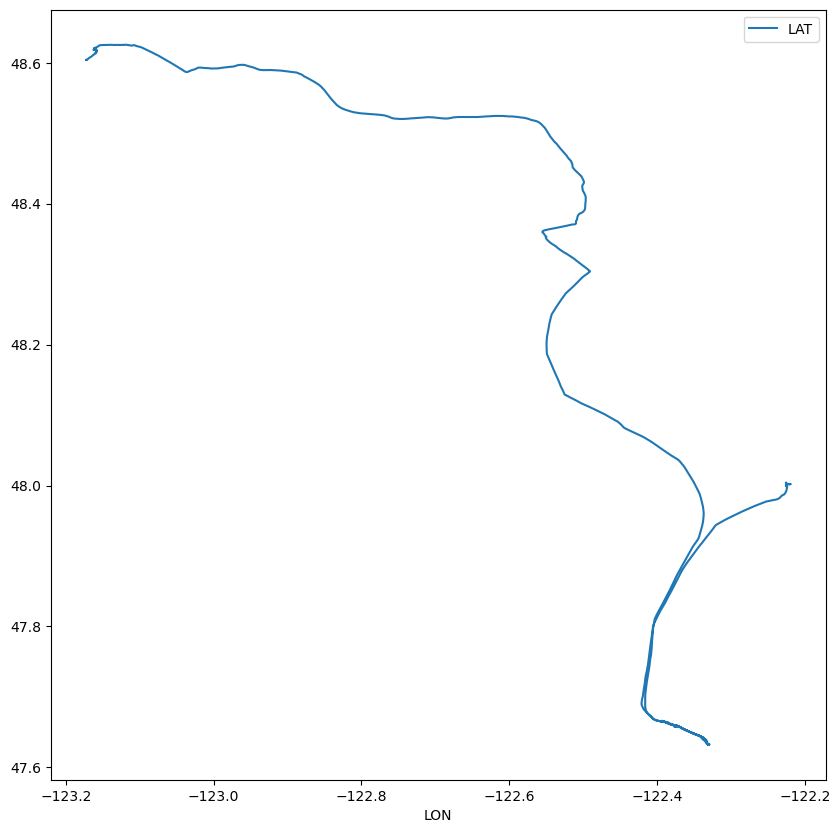

In [19]:
rec1.plot(kind='line', x='LON', y='LAT', figsize=(10,10))
plt.show()

In [ ]:
mapit = folium.Map(location=[moving['LAT'].mean(), moving['LON'].mean()], zoom_start=9)
for coord in moving_points:
    folium.Circle(location=[coord[0], coord[1]], color='green', radius=3).add_to(mapit)

mapit.save('face.html')

In [ ]:
moving

In [109]:
temp = []
for i in range(len(rec1)):
    temp.append((rec1['LAT'][i], rec1['LON'][i]))

In [113]:
mapit = folium.Map(location=[rec1['LAT'].mean(), rec1['LON'].mean()], zoom_start=9)
for coord in temp:
    folium.Circle(location=[coord[0], coord[1]], color='green', radius=3).add_to(mapit)

mapit.save('face.html')

In [111]:
rec1

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,counts
0,367531260,2017-01-01T00:00:00,46.16906,-123.91375,0.0,0.0,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
1,367531260,2017-01-01T00:01:16,46.16907,-123.91376,0.0,0.0,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
2,367531260,2017-01-01T00:02:17,46.16905,-123.91378,0.0,0.0,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
3,367531260,2017-01-01T00:03:19,46.16905,-123.91376,0.0,0.0,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
4,367531260,2017-01-01T00:04:25,46.16903,-123.91373,0.0,0.0,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39445,367531260,2017-01-31T23:55:11,46.52273,-124.27290,7.2,-141.9,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
39446,367531260,2017-01-31T23:56:13,46.52295,-124.27582,8.0,-131.5,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
39447,367531260,2017-01-31T23:57:19,46.52262,-124.27924,7.1,-155.9,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN
39448,367531260,2017-01-31T23:58:20,46.52236,-124.28218,7.2,-135.2,511.0,SOUTHEAST,IMO8855994,WDG3942,1001.0,under way using engine,20.12,6.71,NaN,NaN,NaN


<Axes: xlabel='x'>

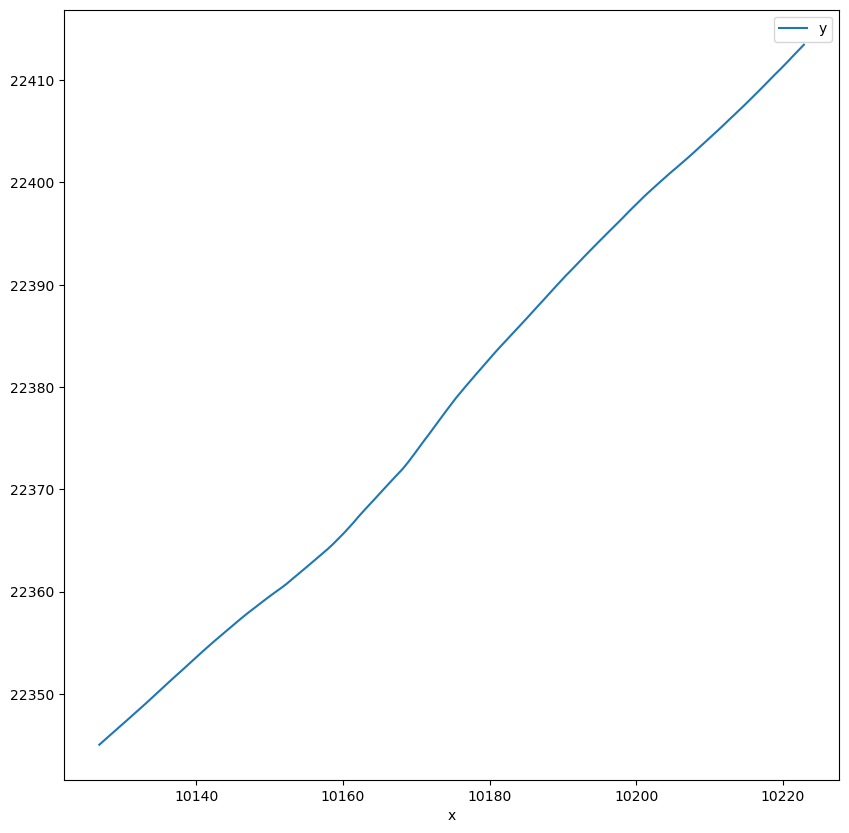

In [131]:
st = 394
temp_df = moving[st:st+m]
temp_df.plot(kind='line', x='x', y='y', figsize=(10,10))